# Метрические классификаторы

## Reading data

In [1]:
import numpy as np
import pandas as pd

%pylab inline
%load_ext autoreload
%autoreload 2

from knn import *

#Read csv training and testing data
df_train = pd.read_csv('kaggle_data/train.csv')
df_test = pd.read_csv('kaggle_data/test.csv')

#Populate numpy arrays
X_train, Y_train = df_train[df_train.columns[1:]].values, df_train['label'].values
X_test = df_test.values

#Shuffle training data
perm = np.random.permutation(len(X_train))
X_train = X_train[perm]
Y_train = Y_train[perm]

Populating the interactive namespace from numpy and matplotlib


## Visualizing data

Сначала попробуем нарисовать элементы из выборки train.csv. Поскольку все картинки маленькие, при визуализации было решено отказаться от билинейной или более высокоуровневой фильтрации и использовать интерполяционный метод 'nearest'.

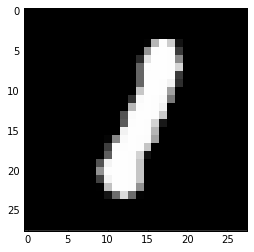

In [2]:
plot_image(X_train[0])

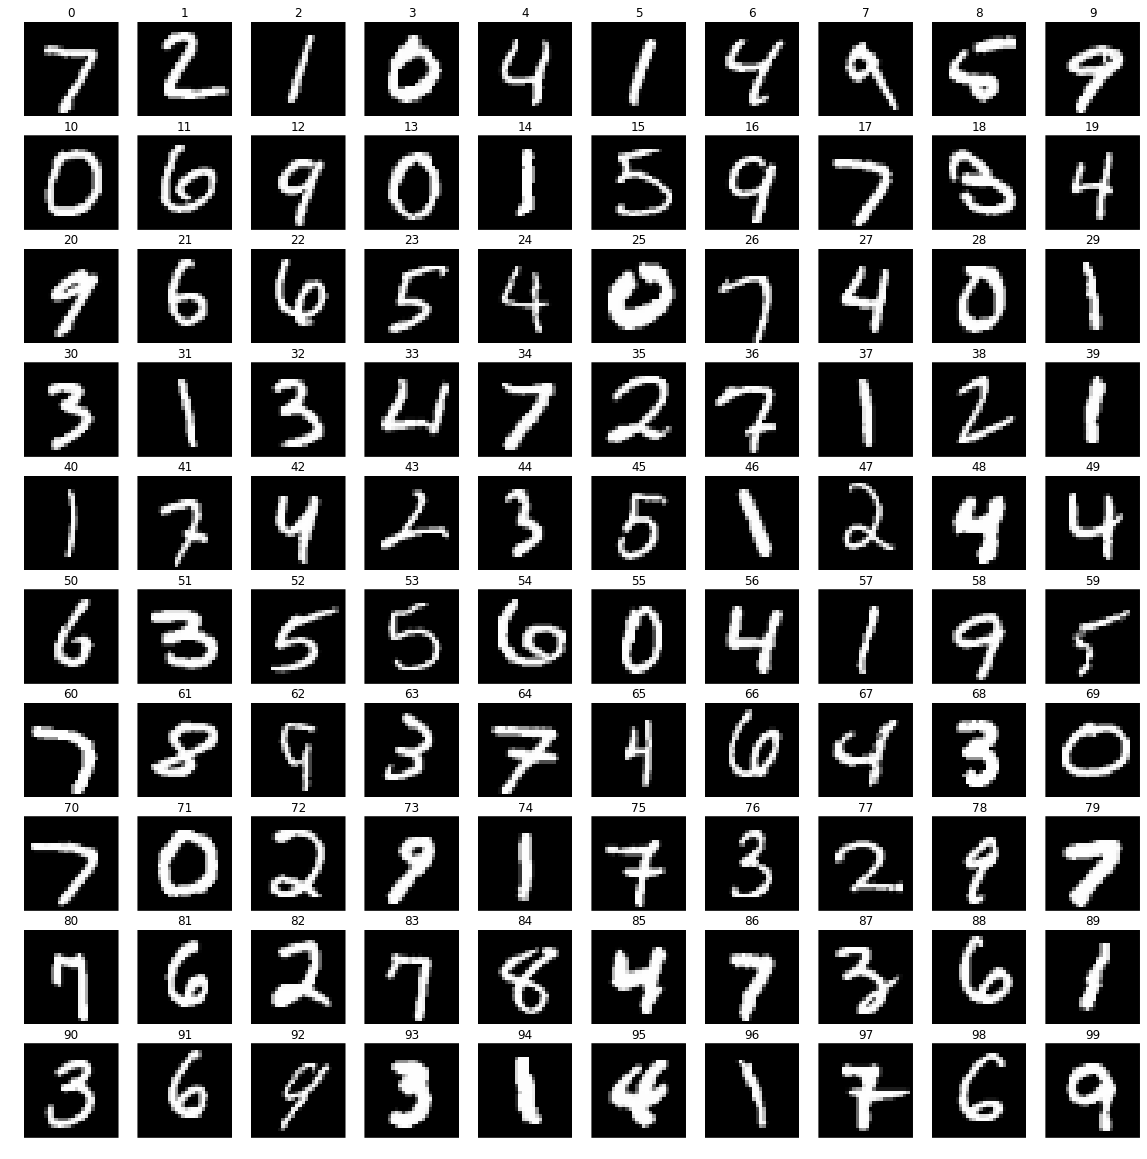

In [3]:
plot_grid(X_test[:100], 10, 10)

## Average digit 

Покажем, как выглядит средний представитель класса.

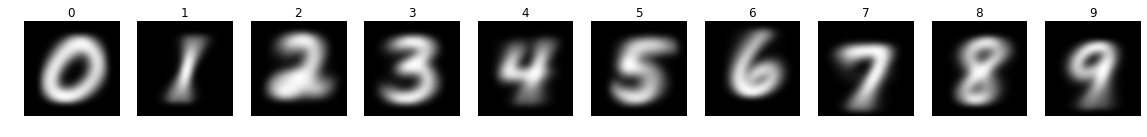

In [4]:
average_digit = []

for c in range(10):
    c_digits = df_train[df_train['label'] == c][df_train.columns[1:]].values
    average_c_digit = numpy.average(c_digits, 0)
    average_digit.append(average_c_digit)
    
plot_grid(average_digit, nrows=1, ncols=10, interpol='bicubic')

А тут мы уде используем бикубическую фильтрацию, посколько все ранво рисуем средние. Почему-то получилось, что семерка немного смещена от центра вниз, а шетсерка -- наоборот вверх

## Matrix Based KNN

Напишем kNN с использованием матрицы расстояний. Класс MatrixBasedKNearestNeighbor можно найти в файле knn.py

In [5]:
def runAndTest(knn, test_size):
    knn.fit(X_train[test_size:], Y_train[test_size:])
    y_pred = knn.predict(X_train[:test_size])
    print("Accuracy: " + str(accuracy(Y_train[:test_size], y_pred)))
    return y_pred

def runAndViz(knn, test_size):
    y_pred = runAndTest(knn, test_size)
    print(y_pred)
    plot_grid(X_train[:test_size], 10, 10)

Сначала протестируем самый медленный вариант -- заполнение dist_mt кодом на питоне

#Two loops
knn = MatrixBasedKNearestNeighbor(num_loops=2)
%time y_pred2 = runAndTest(knn, 100)

Теперь вариант побыстрее -- с помощью numpy посчитаем расстояние от объекта тестовой выборки до всех обхектов тренирововнчый выборки

In [6]:
#One loop
knn = MatrixBasedKNearestNeighbor(num_loops=1)
%time y_pred1 = runAndTest(knn, 100)

Accuracy: 0.94
CPU times: user 7.47 s, sys: 4.22 s, total: 11.7 s
Wall time: 11.9 s


Проверим, что результаты первого и второго вариантов совпадают.

In [96]:
#Check
print('good' if sum(y_pred1 - y_pred2) < 1e-4 else 'fail')

good


Теперь напишем версию без циклов -- только с помощью перемножения и сложения матриц и numpy

In [7]:
#No loops
knn = MatrixBasedKNearestNeighbor(num_loops=0)
%time y_pred0 = runAndTest(knn, 100)

Accuracy: 0.94
CPU times: user 1.51 s, sys: 63.9 ms, total: 1.57 s
Wall time: 1.59 s


Проверяем, что результат совпадает

In [98]:
#Check
print('good' if sum(y_pred0 - y_pred2) < 1e-4 else 'fail')

good


## KDTree KNN

Теперь протестируем версию KNN использующую sklearn.neighbors.KDTree

In [99]:
knn = KDBasedKNearestNeighbor()
%time y_pred_kd = runAndTest(knn, 100)

Accuracy: 0.95
CPU times: user 4.28 s, sys: 24 ms, total: 4.31 s
Wall time: 4.31 s


In [100]:
#check yourself
print('good' if sum(y_pred0 - y_pred_kd) < 1e-4 else 'fail')

good


Вообще она работает медленнее матричного умножения, много времени тратиться на построение самого дерева. Это видно, если отдельно запустить fit и predict. Кроме того, в KDTree нельзя передать произвольную функцию расстояния -- только функции, удовлетворяющие аксиомам метрики. Поэтому было решено далее везде использовать MatrixBasedNearestNeighbour с матричным умножением

## Cosine KNN

Ради интереса я еще реализовал косинусную метрику. Полное сравнение метрик можно будет увидеть далее.

In [101]:
knn = MatrixBasedKNearestNeighbor(num_loops = 0, distance='cosine')
%time y_pred_cosine = runAndTest(knn, 100)

Accuracy: 0.95
CPU times: user 1.34 s, sys: 52.2 ms, total: 1.39 s
Wall time: 1.4 s


## Уделение шумовых объектов

Для каждого объекта посчитаем его margin -- это расстояние от этого объекта до собственного класса минус минимальное расстояние от объекта до любого другого класса. В качестве меры растояния от цифры до класса возьмем сумму расстояний от цифры до 3 других ближайших цифр из класса.

In [6]:
from sklearn.neighbors import KDTree

kdtrees = []
num_train = len(X_train)
X_train_digits = []
for i in range(10):
    X_train_digits.append(X_train[Y_train[np.arange(num_train)] == i])
    kdtrees.append(KDTree(X_train_digits[i]))
    
def simk(x, y, k):
    _, idxs = kdtrees[y].query(x.reshape(1, -1), k = k)
    return (X_train_digits[y])[idxs[0]]

def dist_to_class(x, y):
    dists, idxs = kdtrees[y].query(x.reshape(1, -1), k = 3)
    sum = 0
    for elem in dists[0]:
        sum += elem
    return sum

def dist_to_self_class(x, y):
    dists, idxs = kdtrees[y].query(x.reshape(1, -1), k = 4)
    sum = 0
    for i in range(1, len(dists[0])):
        sum += dists[0][i]
    return sum

def margin(x, y, debug=True):
    min_dist = 1000000000
    self_dist = dist_to_self_class(x, y)
    if (debug):
        print("Self dist: " + str(self_dist))
    for i in range(10):
        dist_to_class_i = dist_to_class(x, i)
        if (debug):
            print(i, dist_to_class_i)
        if (i != y):
            min_dist = min(min_dist, dist_to_class_i)
    if (debug):
        print("Min other dist: " + str(min_dist))
    return min_dist - self_dist

Протестируем метод simk -- он находит k ближайших соседей из заданного класса

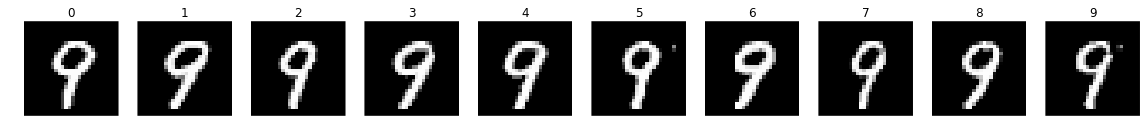

In [13]:
plot_grid(simk(X_train_digits[9][8], 9, 10), ncols=10, nrows=1)

Теперь отсортируем все margin внутри каждого класса и покажем эти зависимости в виде графика.

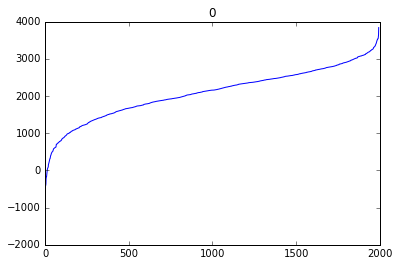

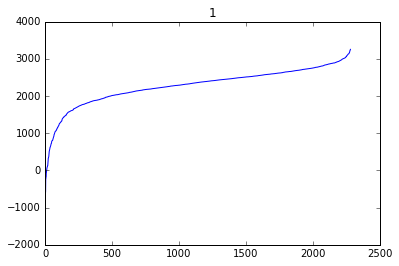

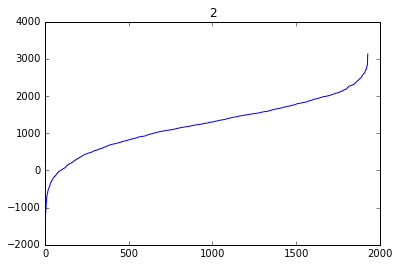

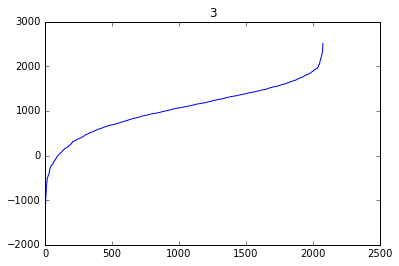

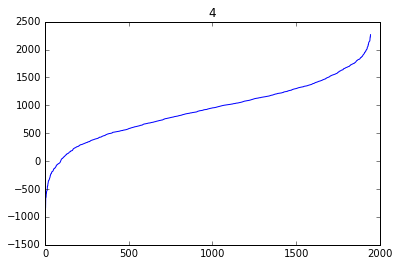

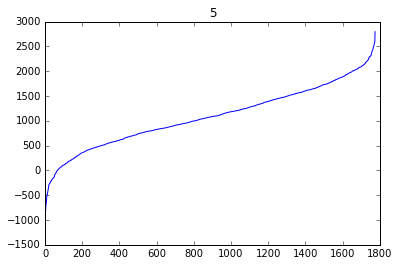

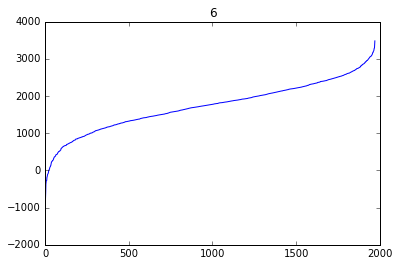

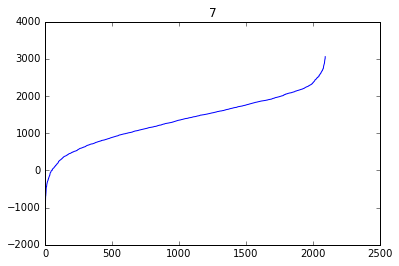

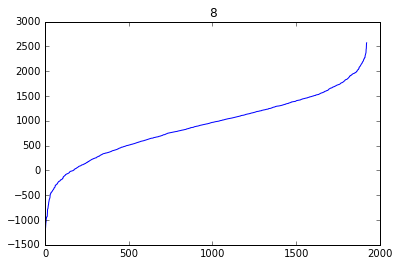

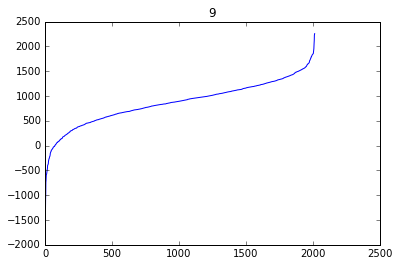

In [16]:
ans = [[] for i in range(0, 10)]
for digit in range(10):
    for i in range(len(X_train_digits[digit])):
        m = margin(X_train_digits[digit][i], digit, debug=False)
        ans[digit].append((m, i))
    ans[digit] = sorted(ans[digit])
    plt.title(str(digit))
    plt.plot(list(map(lambda x: x[0], ans[digit])))
    plt.show()

Посмотрим на шумовых представителей каждого класса

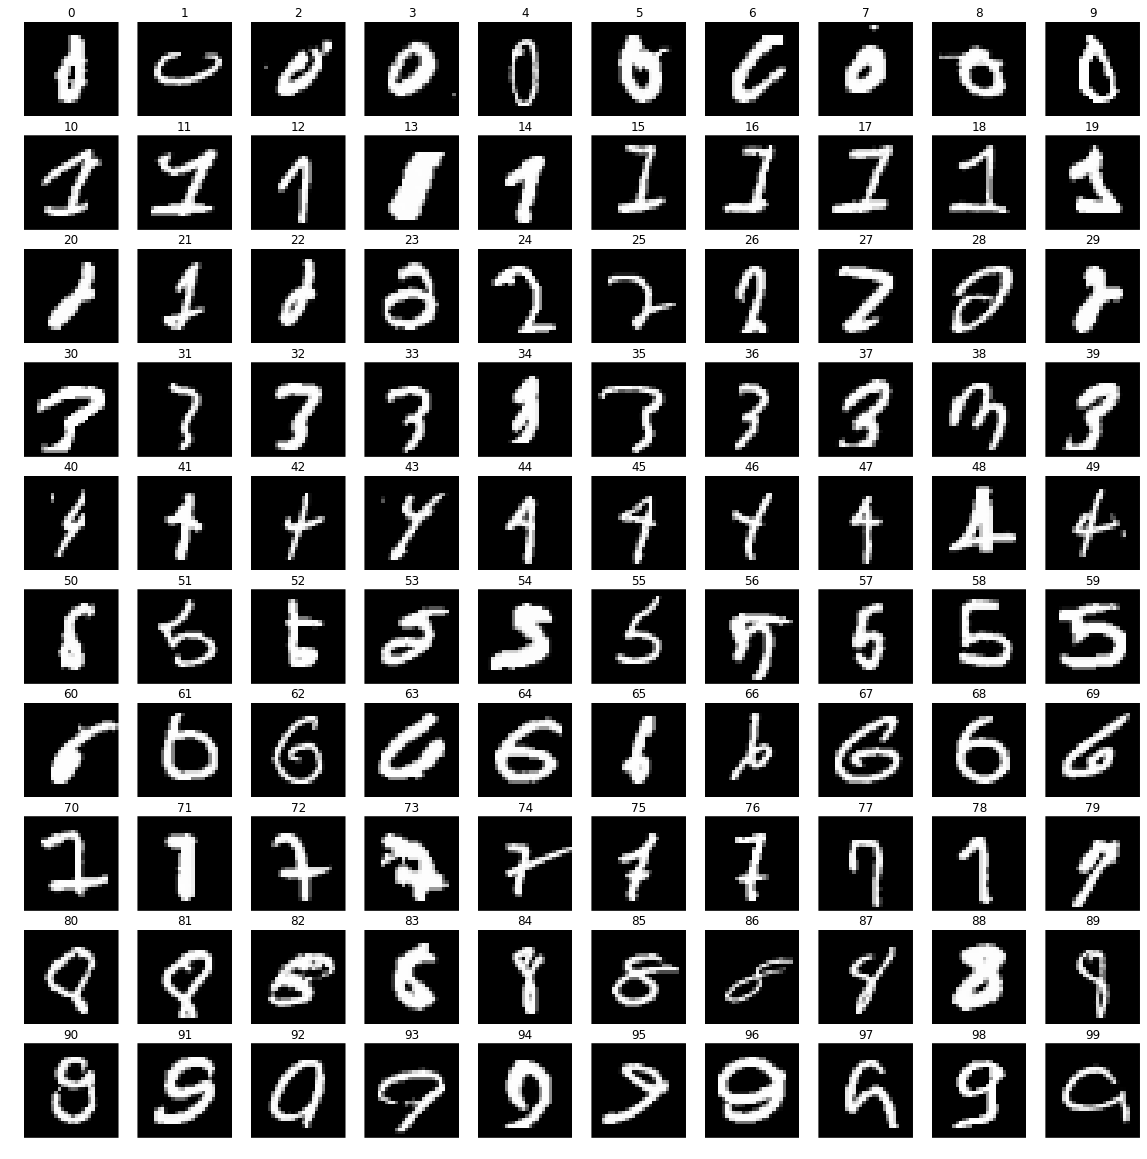

In [21]:
bad = []
for d in range(10):
    bad.extend(map(lambda x: X_train_digits[d][x[1]], ans[d][:10]))
plot_grid(bad, 10, 10)

А теперь на эталонных

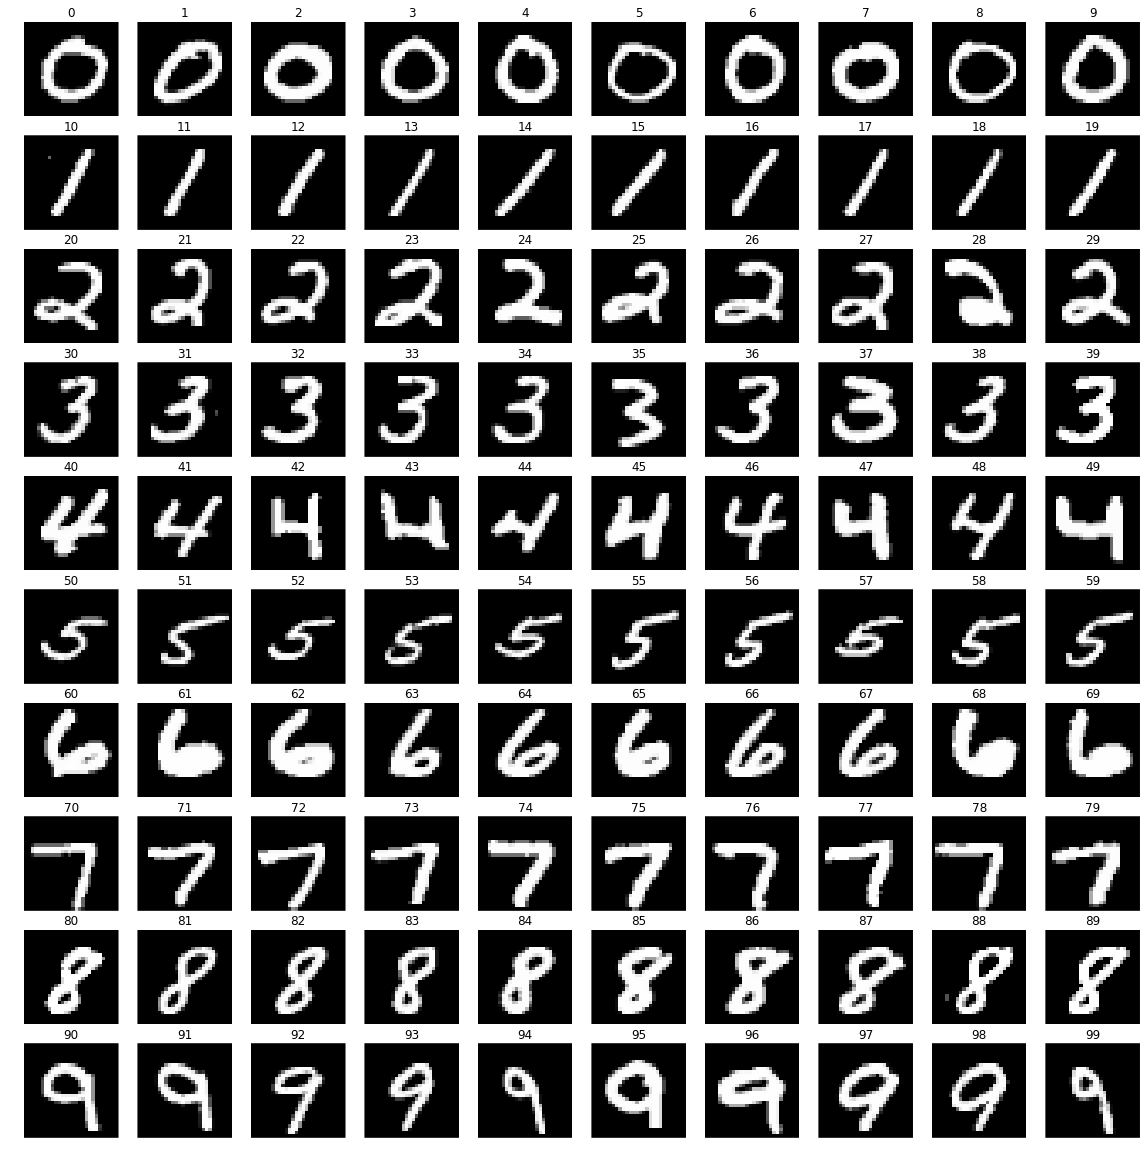

In [23]:
prototypes = []
for d in range(10):
    prototypes.extend(map(lambda x: X_train_digits[d][x[1]], ans[d][-10:]))
plot_grid(prototypes, 10, 10)

Выглядит правдоподобно

На основании этих данных заполним массив cutoffs -- это те значения margin, после которых, как мне кажется, идут шумовые объекты. Интересно заметить, что значение cutoff изменяется от цифры к цифре, так как некоторые из них распознаются гораздо лучше других. Заполним массив X_new -- это X_train без шумовых объектов

In [25]:
cutoffs = [500, 1500, 0, 0, 0, 0, 500, 300, 0, 0]
X_new = []
Y_new = []
for i in range(10):
    for j in range(len(ans[i])):
        if (ans[i][j][0] >= cutoffs[i]):
            X_new.append(X_train_digits[i][j])
            Y_new.append(i)

X_new = np.array(X_new)
Y_new = np.array(Y_new)
print(X_new.shape)
print(Y_new.shape)

(19002, 784)
(19002,)


Нарисуем некоторых его представителей

[7 0 8 1 1 5 8 2 8 0 0 3 1 1 2 5 3 7 4 6 6 6 0 7 0 6 7 7 7 7 4 5 8 5 1 2 4
 6 9 3 2 6 2 9 1 4 0 4 7 3 7 9 9 1 0 9 8 8 7 7 4 3 9 9 7 9 9 4 4 1 3 3 0 2
 3 7 2 6 7 8 8 1 4 1 1 5 1 5 5 5 9 6 9 6 0 4 7 2 9 4]


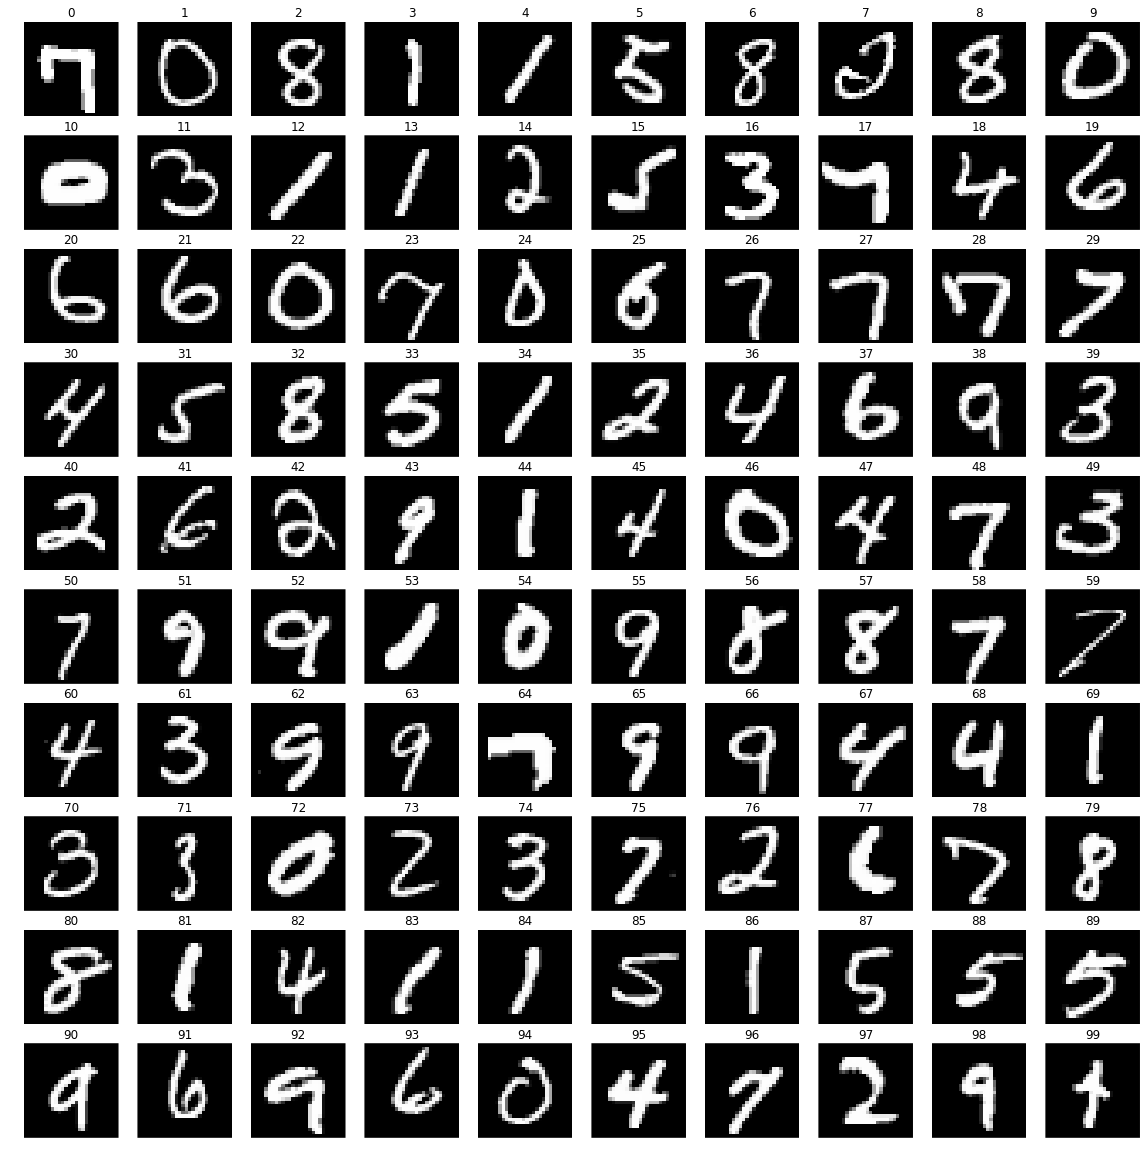

In [26]:
perm = np.random.permutation(len(X_new))
X_new = X_new[perm]
Y_new = Y_new[perm]
print(Y_new[:100])
plot_grid(X_new[:100], 10, 10)

## Удаление шумовых объектов -- тест

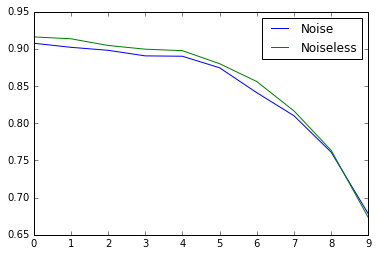

In [32]:
ks = [1, 3, 5, 7, 9, 15, 30, 50, 100, 200]

res_noiseless = []
for k in ks:
    knn = MatrixBasedKNearestNeighbor(k = k, distance='l2')
    acc = cross_validation(X_new[:2000], Y_new[:2000], knn)
    res_noiseless.append(acc)
    
res_noise = []
for k in ks:
    knn = MatrixBasedKNearestNeighbor(k = k, distance='l2')
    acc = cross_validation(X_train[:2000], Y_train[:2000], knn)
    res_noise.append(acc)

plt.plot(res_noise, label='Noise')
plt.plot(res_noiseless, label='Noiseless')
pylab.legend(loc='upper right')
plt.show()

Получили результат где-то на 1% лучше, что довольно хорошо

## Cross Validation

Алгоритм кросс валидации находиться в файле knn.py. По умолчанию используется 10-fold, но этот параметр можно задать в функции cross_validation
Сначала протестируем зависимость CV Accuracy от размера выборки.

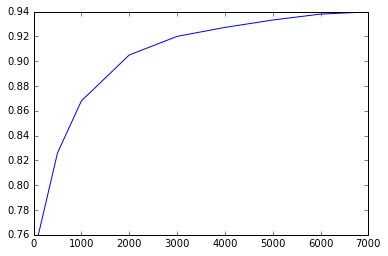

In [37]:
sizes = [100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000]
knn = MatrixBasedKNearestNeighbor()
res = []
for size in sizes:
    acc = cross_validation(X_train[:size], Y_train[:size], knn)
    res.append(acc)
plt.plot(sizes, res)
plt.show()

Мы для ускорения вычислений далее будем использовать размер выборки 2000

Проведем теперь самый общий тест: протестируем метод парзеновского окна с разными метриками, ядрами и с разными k. Заметим, что при ядре 'rect' метод парзеновского окна является самым обычным kNN

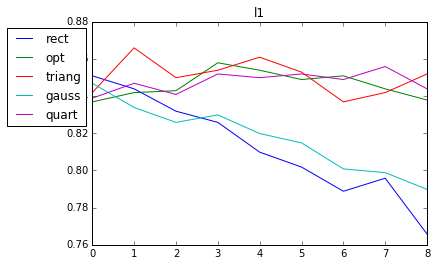

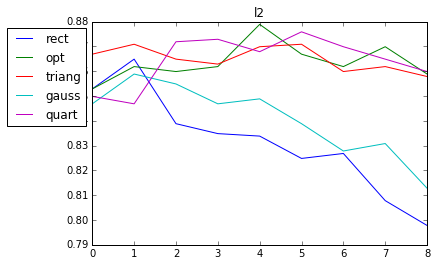

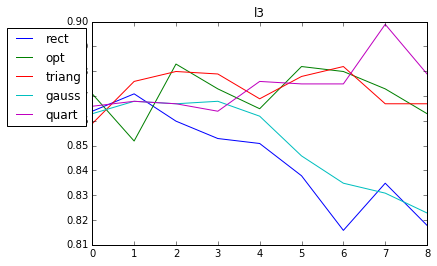

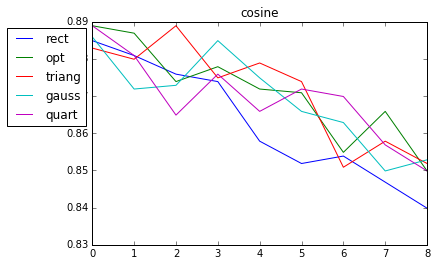

In [43]:
metrics = ['l1', 'l2', 'l3', 'cosine']
kernels = ['rect', 'opt', 'triang', 'gauss', 'quart']
ks = [1, 3, 5, 7, 9, 11, 13, 15, 17]
for metric in metrics:
    plt.figure()
    plt.title(metric)
    for kernel in kernels:
        res = []
        for k in ks:
            num_loops = 0
            if (metric == 'l1' or metric == 'l3'):
                num_loops = 1
            knn = MatrixBasedKNearestNeighbor(k = k, kernel = kernel, distance = metric, num_loops = num_loops)
            acc = cross_validation(X_train[:1000], Y_train[:1000], knn, cv_fold = 3)
            res.append(acc)
        plt.plot(res, label = kernel)
    plt.legend(bbox_to_anchor=(0, 1), loc = 'upper right', ncol = 1)
    plt.show()

Видно, что 'rect' ведет себя хуже остальных, а 'gauss' хорошо работает только в случае косинусной метрики. Однако, стоит отметить, что косинусный 1NN алгоритм уделывает l1 и l2 алгоритмы с парзеновским окном и только l3 c ядром 'quart' его обгоняет

## Kaggle

На Kaggle было решено отправить два алгоритма - 1NN с косинусной метрикой и 7NN c оптималтным парзеновским окном. Несмотря на то, что отсеивание шума хорошо показало себя локально, на Kaggle оно не зашло, возможно из-за того, что данные, которые приходится предсказывать, также содержат в себе некоторый шум.

In [80]:
knn = MatrixBasedKNearestNeighbor(num_loops=0, k = 7, distance='cosine', kernel='opt')
knn.fit(X_train, Y_train)
%time Y_test_cosine = knn.predict(X_test)

CPU times: user 1min 29s, sys: 1.72 s, total: 1min 31s
Wall time: 1min 33s


In [81]:
out = pd.DataFrame(data=list(map(int, Y_test_cosine)), columns=['label'])
out.to_csv('kaggle_data/out_cosine_parsen.csv')

## Вывод

Метрические алгоритмы (simple KNN, алгоритм парзеновского окна и другие) достаточно хорошо себя ведут в задачах классификации, когда исходные данные отцентрированны и отнормированы. Чтобы повысить точность классификации можно перебрать различные метрики и виды ядра. Самый простым в реализации и быстрым алгоритмом на практике оказался 1NN с косинусной метрикой. Лучшие результаты на Kaggle показал 7NN с оптимальным парзеновским окном и косинусной метрикой.

Стоит сказать, что перебор метрик и окон не единтсвенный возможный путь улучшения. Еще один вариант -- преобразовать исодные данные. Было реализовано отсеивание шумовых объектов на основе margin -- оно достаточно хорошо показало себя локально, но на Kaggle получило не самый лучший score. Еще один вариант -- преобразовать feature space, например, воспользоваться гамма коррекцией чтобы привести данные в формат linear colorspace. Или можно привести интенсивности к значению из множества $\{0, 1\}$, например, обрезав все интенсивности, которые < 0.5